# RNN을 이용한 텍스트 생성기(Text Generator using RNN)
## 샘플 코드를 기반으로 한 텍스트 생성 프로그램입니다.(Text Generator based on sample code)
### 한국어 설명
그럴듯한 텍스트 생성을 위해서는 최소 5000 Epoch의 학습이 필요합니다.
<br> 이 코드는 Keras 예제, Tensorflow 예제와 같은 코드를 참고하여 제작되었습니다.
<br>
<br> 몇가지 유의사항:
<br>- 이 프로그램은 대용량 텍스트 처리에 적합하지 <b>않습니다</b>.
<br>- 이 프로그램은 모든 언어에 대응합니다. (일단, 한국어 구동은 확인했습니다.)
<br>- RNN의 계산량이 매우 많음에 따라 GPU환경에서 구동하는 것을 추천드립니다.
<br>
### EN Version.
At least 5000 epochs are required before the generated text starts sounding coherent.
<br> *(This model is inspired by many examples, such as Keras samples, or tensorflow tutorials.)*
<br>
<br> Few notices:
<br>- This script is <b>NOT</b> designed for large text.
<br>- This script is designed for ANY language. (It works for my language, at least.)
<br>- It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.

In [1]:
import os
import csv
import time
import chardet
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Twitter
from tensorflow.contrib.tensorboard.plugins import projector

%matplotlib inline

C:\Users\jungw\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Class 상세
- \_\_init\_\_: 인코딩(Encoding) 옵션과 함께 파일을 로드합니다.
    - 기본 인코딩: None
- Slice_Data: 텍스트를 글자 단위로 분할합니다. (올바른 방법으로 수정할 경우, 단어 단위로도 가능)
- Data2idx: 텍스트 데이터를 인덱스(Index)로 변환합니다.
- Build_Data: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본 Stride: 1
- LSTM_Cell: rnn.MultiRNNCell에서 쓰이는 LSTM 셀 구조
- Make_Text: 텍스트 데이터를 기반으로 텍스트를 생성합니다.
- Elapsed: 작업 경과시간 측정 용도
- Save_Model: 현재 모델을 저장합니다.
    - Default Global_step: 1000
- Load_Model: 특정 모델 파일을 불러옵니다.
- Plot_Iter_Loss: Matplotlib을 사용하여 Iteration대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Loss: 시간대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Iter: Iteration대비 시간 경과를 그래프로 그려줍니다.
- Prepare_Model: 학습을 위한 모델 구조를 생성합니다. (X, Y, weight 등)
- Train: 지정된 Epoch숫자만큼 학습을 진행합니다.

### Class Details
- \_\_init\_\_: Load file with encoding option.
    - Default Encoding: None
- Slice_Data: Split text data into characters (This can be words if modified correctly)
- Data2idx: Transform text data into index
- Build_Data: Generate sequences of transformed text data
    - Default Stride: 1
- LSTM_Cell: A LSTM cell, only to use at rnn.MultiRNNCell
- Make_Text: A random text generator, based on text data
- Elapsed: To calculate time elapsed
- Save_Model: Save current Neural Network model
    - Default Global_step: 1000
- Load_Model: Load specified model file
- Plot_Iter_Loss: Plot loss compared to total iteration, using matplotlib.
- Plot_Time_Loss: Plot loss compared to time.
- Plot_Time_Iter: Plot Time compared to total iteration.
- Prepare_Model: Generate model structure for training (X, Y, weight, etc.)
- Train: Start training model with epoch number followed

In [2]:
class TextGen:

    def __init__(self, filename, learning_rate, num_layers, seq_len, epoch,
         save_point, save_at, encode=False, chunk_word=False, stride=1):
        self.filename = filename
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.epoch = epoch
        self.save_point = save_point
        self.save_at = save_at
        self.encode = encode
        self.stride = stride
        self.chunk_word = chunk_word

    def read_dataset(self):
        try:
            read_file = open(self.filename, 'rb').read()
            if self.encode is True:
                encode_type = chardet.detect(read_file)['encoding']
                print(encode_type)
            else:
                encode_type = None
            # text = open(full_filename, encoding=None).read().lower()
            text = open(self.filename, encoding=encode_type).read()
        except:
            text = False
        if self.chunk_word is True:
            text.replace(' ', " SPACE ")
            text.replace('\n', " ENTER ")
        print("Load Complete.")
        return text

    def Slice_Data(self):
        if self.chunk_word is True:
            twitter = Twitter()
            self.text = twitter.morphs(self.text)
            self.text = [' ' if word is "SPACE" else word for word in self.text]
            self.text = ['\n' if word is "ENTER" else word for word in self.text]
        
        vocabulary = sorted(list(set(self.text)))    # character split
        vocabulary_size = len(vocabulary)
        vocab_ids = dict((c, i) for i, c in enumerate(vocabulary))
        ids_vocab = dict((i, c) for i, c in enumerate(vocabulary))
        print("Slice Complete.")
        return vocabulary, vocabulary_size, vocab_ids, ids_vocab

    def Data2idx(self):
        idx_text = []
        for element in self.text:
            idx_text.append(self.vocab_ids[element])
        text = idx_text
        print("Indexing Complete.")
        return text

    def Build_Data(self):
        x_data = []
        y_data = []
        for i in range(0, len(self.text) - self.seq_len, self.stride):
            fill_x = self.seq_len - len(self.text[i : i+self.seq_len])
            fill_y = self.seq_len - len(self.text[i+1 : i+self.seq_len - 1])
            
            x_text = self.text[i : i+self.seq_len]
            y_text = self.text[i+1 : i+self.seq_len - 1]
            
            if fill_x is not 0:
                x_text.extend([0 for i in range(fill_x)])
            elif fill_y is not 0:
                y_text.extend([0 for i in range(fill_y)])

            x_data.append(x_text)
            y_data.append(y_text)
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        print("Sequencing Complete.")
        return x_data, y_data

    def Make_CSV(self, filename):
        with open(filename, 'w') as f:
            writer = csv.writer(f, lineterminator='\n')
            for element in self.vocabulary:
                writer.writerow([element])

    def Make_Text(self, sess):
        self.results = sess.run(self.outputs, feed_dict={self.X: self.x_data})
        for j, result in enumerate(self.results):
            index = np.argmax(result, axis=1)
            if j is 0:  # print all for the first result to make a sentence
                print(''.join([self.ids_vocab[t] for t in index]), end='')
            else:
                print(self.ids_vocab[index[-1]], end='')

    def LSTM(self):
        lstm = tf.contrib.rnn.BasicLSTMCell(self.hidden_size,
                                            state_is_tuple = True)
        return lstm

    def BRNN_Dynamic(self, X):
        # Default activation: Tanh
        # Default: state_is_Tuple=True
        # lstm = tf.contrib.rnn.BasicLSTMCell(self.hidden_size, state_is_tuple = True)
        lstm = tf.nn.rnn_cell.DropoutWrapper(self.LSTM(), output_keep_prob=0.8)    # Dropout 0.8
        multi_lstm = tf.contrib.rnn.MultiRNNCell([lstm]*self.num_layers,
                                                state_is_tuple = True)
        # Bidirectional Dynamic RNN
        (fw_output, bw_output), _states = tf.nn.bidirectional_dynamic_rnn(cell_fw=multi_lstm,
                                                                        cell_bw=multi_lstm,
                                                                        inputs=X,
                                                                        dtype=tf.float32)
        outputs = tf.concat([fw_output, bw_output], axis=2)
        return outputs

    def MultiRNN_Dynamic(self, X):
        lstm = self.LSTM()
        # lstm = tf.nn.rnn_cell.DropoutWrapper(self.LSTM(), output_keep_prob=0.9)
        multi_lstm = tf.contrib.rnn.MultiRNNCell([lstm] * self.num_layers,
                                                 state_is_tuple = True)
        outputs, _states = tf.nn.dynamic_rnn(multi_lstm,
                                             X,
                                             dtype=tf.float32)
        return outputs
  
    def Elapsed(self):
        total = self.end - self.start
        m, s = divmod(total, 60)
        h, m = divmod(m, 60)
        
        if m == 0 and h == 0:
            print("Time Elapsed: {:>3d} sec".format(int(s)))
        elif m != 0 and h == 0:
            print("Time Elapsed: {:>3d} min {:>3d} sec".format(int(m), int(s)))
        else:
            print("Time Elapsed: {:>3d} hour {:>3d} min {:>3d} sec".format(int(h), int(m), int(s)))
            
    def Save_Model(self, saver, sess, iter, output=True):
        pathfile, ext = os.path.splitext(self.save_at)
        file = pathfile + '_' + str(iter) + ext
        save_model = saver.save(sess, file)
        if output is True:
            print("Model saved in path: %s" % save_model)
        
    def Plot_Loss(self):
        fig = plt.figure(figsize=(14, 12))
        graph_1 = fig.add_subplot(2, 1, 1)
        graph_1.grid()
        graph_2 = fig.add_subplot(2, 1, 2)
        graph_2.grid()
        graph_1.plot(self.iter_loss,
                     label='Loss v. Iter')
        graph_2.plot(self.elapsed,
                     self.iter_loss,
                     label='Loss v. Time')
        
        graph_1.set_xlabel('Iter')
        graph_1.set_ylabel('Loss')
        graph_1.set_title('Loss vs Epoch')
        graph_2.set_xlabel('Time(sec)')
        graph_2.set_ylabel('Loss')
        graph_2.set_title('Loss vs Time')
        plt.show()
        
    def Plot_Time_Iter(self):
        plt.figure()
        plt.plot(self.elapsed)
        plt.xlabel('Iter')
        plt.ylabel('Time')
        plt.title('Iter vs Time')
        plt.show()

    def Prepare_Model(self):
        
        # load data
        self.text = self.read_dataset()
        self.vocabulary, self.vocabulary_size, self.vocab_ids, self.ids_vocab = self.Slice_Data()
        self.text = self.Data2idx()
        self.x_data, self.y_data = self.Build_Data()

        print("Text length: %s" % len(self.text))
        print("Number of characters: {}".format(self.vocabulary_size))    # length check
        print("Dataset X has {} sequences.".format(len(self.x_data)))    # dataset shape check
        print("Dataset Y has {} sequences.".format(len(self.y_data)))
        print("Dataset X has {} shape.".format(self.x_data.shape))

        # batch_size: Mini batch size
        # data_dims: How many features at once? (Characters, Words, etc.)
        # output_dim: How many features per output?
        # seq_len: How many sequences per output?
        self.batch_size = len(self.x_data)
        self.data_dims = len(self.x_data)
        self.hidden_size = self.vocabulary_size
        
        self.X = tf.placeholder(tf.int32, [None, self.seq_len])
        self.Y = tf.placeholder(tf.int32, [None, self.seq_len])

        # One-hot encoding
        # X_one_hot = tf.one_hot(self.X, self.vocabulary_size)
        # print(X_one_hot)
        
        # Embedding, with input dimension of vocab size
        self.embedding = tf.get_variable("embedding", [self.seq_len, self.vocabulary_size], dtype=tf.float32)
        embed = tf.nn.embedding_lookup(self.embedding, self.X)
        
        # LSTM Cell
        outputs = self.MultiRNN_Dynamic(embed)
        
        # Add Softmax Layer
        # input_fc = tf.reshape(outputs, [-1, self.hidden_size])    # If one-hot encoded...
        self.outputs = tf.contrib.layers.fully_connected(outputs,
                                                        self.vocabulary_size,
                                                        activation_fn=None)

        # Initialize fc weights with Ones
        # If all weights are not same, loss will explode!!
        weights = tf.ones([self.batch_size, self.seq_len])

        # Monitor loss
        loss = tf.contrib.seq2seq.sequence_loss(logits=self.outputs,
                                                targets=self.Y,
                                                weights=weights)
        self.mean_loss = tf.reduce_mean(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = optimizer.minimize(self.mean_loss)

    def Train(self, sess):
        # Set up initializers
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        print('=' * 20, "{:^20}".format("Training Start"), '=' * 20)

        self.iter_loss = []
        self.elapsed = []
        loss_prev = 99999
        
        self.start = time.time()

        # Begin Training
        for i in range(self.epoch):
            _, l, results = sess.run(
                [self.train_op, self.mean_loss, self.outputs],
                feed_dict={self.X: self.x_data, self.Y: self.y_data})
            self.end = time.time()
            self.elapsed.append(self.end - self.start)    # Time & Iteration
            self.iter_loss.append(l)    # Iteration & Loss
            for j, result in enumerate(results):
                index = np.argmax(result, axis=1)
                if i % 100 == 0 and j == 0:
                    print("\n At step", i, ':',
                        ''.join([self.ids_vocab[t] for t in index]))
                    print('Loss:', l)
                    self.end = time.time()
                    self.Elapsed()
            if loss_prev > l:
                self.Save_Model(saver, sess, "BEST", output=False)
                loss_prev = l
            elif i % self.save_point is 0:
                self.Save_Model(saver, sess, i)

    def Embedding_Tensorboard(self, sess):
        # Tensorboard Embedding Visualization
        filepath = "C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/graphs/Embedding/"
        filename = "vocabs.csv"
        file = filepath + filename
        self.Make_CSV(file)

        sess.run(self.embedding.initializer)    # Initialize Embedding Variable
        config = projector.ProjectorConfig()    # Create Projector config
        embedding = config.embeddings.add()     # Add Embedding Visualizer
        embedding.tensor_name = self.embedding.name     # Attach the name of the variable
        embedding.metadata_path = filename      # Metafile
        writer = tf.summary.FileWriter(filepath, sess.graph)    # Create summary writer
        projector.visualize_embeddings(writer, config)  # Add writer and config to Projector
        saver_embed = tf.train.Saver([self.embedding])  # Save the model
        saver_embed.save(sess, './graphs/Embedding/embedding.ckpt', 1)

## 현재 과정 설명
1. 학습을 위한 모델 구조를 설정합니다. 해당 과정은 다음과 같은 과정을 거칩니다.
    - 기본값 셋팅:
        - text(텍스트 원문): read_dataset과 Data2idx를 이용하여 전처리
            - 이 경우, 텍스트 데이터의 형태를 띄고 있으면 어떤 데이터든 상관없습니다. (txt, py, c, cpp, ...)
        - vocabulary: Character 또는 Word단위의 사전(Dictionary)
        - vocabulary_size(vocab 양)
        - vocab_ids, ids_vocab: vocab을 index로 변환하거나 index를 vocab으로 변환
        - x_data, y_data: Build_Data를 이용하여 Input으로 쓸 x_data와 Output/Truth로 사용할 y_data 생성
    - Input 형태 설정: [None, 시퀀스 길이]
    - Truth 형태 설정: [None, 시퀀스 길이]
    - Word Embedding 진행: 모든 vocabulary에 대한 확률을 Tuple형식으로 가집니다.
    - LSTM을 2중으로 중첩(2-Layer RNN): 현재의 Best Layer개수
    - dynamic_rnn을 거쳐 output을 생성
    - 마지막으로 FC(Fully Connected, DenseNet)를 거쳐 Output(예측값) 생성
        - 이 경우, seq_len만큼의 vocab을 보고 다음에 올 vocab을 예측합니다.
        - 이러한 방법을 CBOW(Continuous Bag of Words)라고 칭하며, 짧은 Context에 적합한 방식입니다.
    - Weight값의 초기화(모두 1로): Output에 대한 Weight
    - Loss: Tensorflow에서 제공하는 sequence_loss를 통해 진행
    - outputs와 실제 Y값을 비교하여 Loss값 산출
    - Loss 평균으로 계산
    - Optimizer 설정
2. Session을 생성합니다.
4. 학습을 시작합니다.
5. Visualization을 위한 Projector설정

## Current process explanation
1. Build model structure. This process goes with following steps:
    - Default setting:
        - text(Original Text): Preprocess with read_dataset, and Data2idx function
        - vocabulary: Dictionary of characters or words
        - vocabulary_size: size of vocabulary
        - vocab_ids, ids_vocab: Convert vocabulary to index number, or index to vocabulary
        - x_data, y_data: Generate x_data for input, y_data for Output/Truth data with Build_Data function
    - Input shape setting: [None, Sequence Length]
    - Truth shape setting: [None, Sequence Length]
    - Process word embedding: Contains possibilities for every vocabs (Tuple type)
    - Stack LSTM twice(2-Layer RNN): Current best hyperparameter
    - Generate output through dynamic_rnn
    - Finally, Generate output through FC(Fully Connected, DenseNet)
        - In this case, predict next vocab by checking seq_len number of vocabs.
        - This method is called CBOW(Continuous Bag of Words), and appropriate method for short context.
    - Initialize Weight value (All equal value, 1): Weight for Output
    - Loss: Process through 'sequence_loss', from Tensorflow module
    - Calculate Loss by comparing outputs and actual Y(Truth)
    - Calculate average loss
    - Set up optimizer
2. Create Session for training.
3. Set path to save Model
4. Begin training
5. Projector setting for visualization

In [3]:
save_at = "C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/Models/rnn_text.ckpt"

In [4]:
code_gen = TextGen(filename = "SAMPLE.py",
                learning_rate = 0.067,
                num_layers = 2,
                seq_len = 60,
                epoch = 2001,
                save_point = 1000,
                save_at = save_at,
                encode=False,
                chunk_word=False,
                stride=1)
code_gen.Prepare_Model()

Load Complete.
Slice Complete.
Indexing Complete.
Sequencing Complete.
Text length: 12033
Number of characters: 75
Dataset X has 11973 sequences.
Dataset Y has 11973 sequences.
Dataset X has (11973, 60) shape.


In [5]:
sess = tf.Session()
code_gen.Train(sess)
code_gen.Embedding_Tensorboard(sess)

====================    Training Start    ====================

 At step 0 : OKKKKKKKOOOOOOOyOO2222222.ppppppp))...................P3SG  
Loss: 4.3144207
Time Elapsed:   1 sec

 At step 100 : ne)


=ea eaalt
n_)
sseaseh_tNN(rN_(rNVEL')=
zz) ne
_

=ese_
Loss: 2.276238
Time Elapsed:   2 min  25 sec

 At step 200 : netil =um eorxe_ocr .)a_siR_LIN_LOG_LEVEL']='n'.
neort =osgi
Loss: 1.5211271
Time Elapsed:   4 min  36 sec

 At step 300 : nslin ium e.rze_eor(s0a_iiP_MIN_LOG_LEVEL']='n'.
nport tasgi
Loss: 1.1497601
Time Elapsed:   6 min  31 sec

 At step 400 : nelut sum e.pxp(ro:ta'F_
PP_MIN_LOG_LEVEL']='2'
import tosgi
Loss: 0.93024105
Time Elapsed:   8 min  22 sec

 At step 500 : nslut =er
earye'oncss'i_CPP_MIN_LOG_LEVEL']='2'_
tport tosgi
Loss: 1.0147874
Time Elapsed:  10 min   2 sec

 At step 600 : nslit sum
aabxe_
op,''F_ihP_MIN_LOG_LEVEL']='2'
import toggi
Loss: 0.7813693
Time Elapsed:  11 min  44 sec

 At step 700 : nelit tpm eaplp_
o
''[(_CPP_MIN_LOG_LEVEL']='2'
import toggi
Loss: 0.7

## 예측 코드 생성
* 학습된 데이터를 기반으로 코드를 생성해 봅시다!

In [6]:
code_gen.Make_Text(sess)

clmmm l
.rmd)

,

_
l(i
 



.n[elnn


.nrtl
[.nl


t.rl
.




n
t(l


nn
(2
tit
nl
li
(t
.(
l
2
t
o

.ent
_

t
ln
o


l.lt
(
his[




tt(

.s.it
l

e




_ms


sn
l(ttil

le

t(n
.
t
ett 
u
eln[l
=tth(l=e
sh
t
tn_




c]
l

s



e
(


tlint




_he
n

ttnttil

t

r
i(



i
te
lti

eiol
hn
ll

's:su
tsieii

t=n=,




tn.r[m
i
ttl(o

tt
i
n
i
tl
n
e

l
ilo'elo
]

ss
b t




ol

tsr



m
l

n

tn
hi

t
e
li

=

nnnll
(

lii



hl

e

l


(_l
)=ltilrt
[
bilo
r
.]te
t

ethn.
(
,nr
tt


tl(
t



in
l


n
lht(
nl

h snll_
s
tnts
ll

tl
hc
,o'l(
n
]


.

elleh
l
lnt
lb
s
n
r(
n

l(st
[l

ttm


l
.s



,l

l
e

s






(
ff.ntii t
is

m
e,




t
ttl


h=
te



m
n








t

tl[
m
o

o
=.
tt=

ex



in
,
n
o

h
elh
(


r
tr

ee

mo,o
nore
=t,(
tlp



n
t
s
s


t,

l(nee


n


nsl
l)
t 
]
ehpn
t
te)



[l(
e

]h

t

ils


pn

il
li




2
[

i,t


t.

ns


li
h
tot
']

r



( llt
tu
[(tnt
t

sy


m
2m(tltilthrt



t
el
(en(





l

t
t




nlc

t
t
.
s

[
(esl==l
a]itl

l



r

m
nm[lltn
(ttt,ol

## 과정 시각화(Process Visualization)
### Iter vs Loss / Time vs Loss
- Iteration별 Loss 변화 추이를 알아봅니다.
- 시간 경과별 Loss 변화 추이를 알아봅니다.

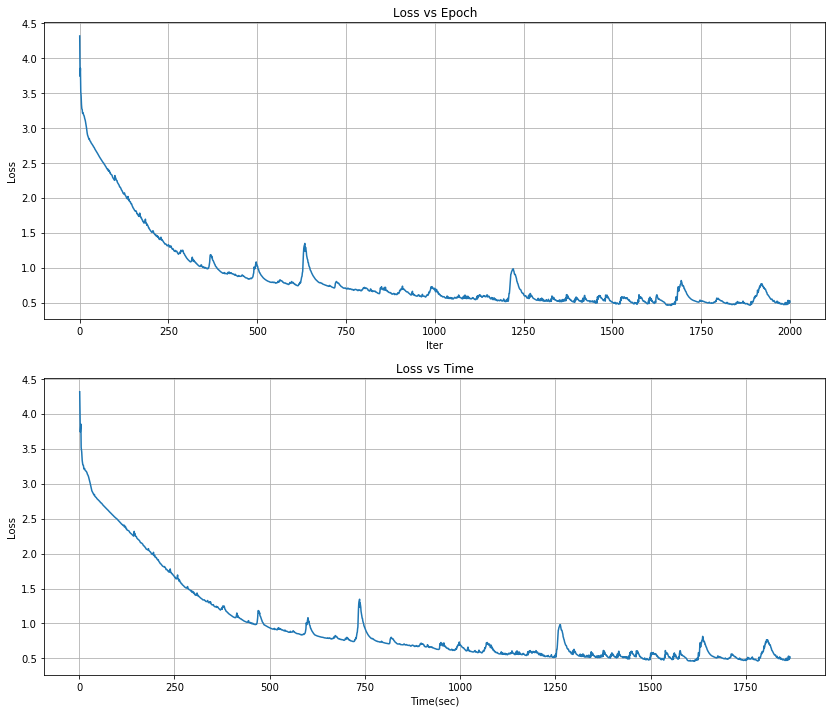

In [7]:
code_gen.Plot_Loss()

### Best 모델과의 비교를 위한 모델 로드
- 저장된 Loss 최저점 당시의 모델을 불러와 예측모델을 생성해봅시다.

In [8]:
saver = tf.train.Saver()
saver.restore(sess, './Models/rnn_text_BEST.ckpt')
code_gen.Make_Text(sess)

INFO:tensorflow:Restoring parameters from ./Models/rnn_text_BEST.ckpt
neort tum eaexeiron['TF_CPP_MIN_LOG_LEVEL']='2'
import logging
import time
import numpy as np
import tensorflow as tf

logging.getLogger('tensorflow')
setLevel(logging.WARNING)

class CharRNN(object):
  
ef _
init__(self, ss
training,
satch_size, nem_lnrollings
 vocab_size, 
                idden_size  max_grad_norm, 
mbedding_size
 n
m_layers,
                earning_rate, model, dropout=0.0, input_dropout=0.0, 
se_batch=True):
    self.match_size * batch_size

   self.voc_unrollings
= n

_unrollings
    if sea use_batch:
      self.match_size * b
      self.noc_unrollings
= n

   self._idden_size,= (idden_size
    self.vocab_iize = vocab_size
    self.m
x_grad_norm
= max_grad_norm
    self.tom_layers
= tum_layers
    self.tmbedding_size
= 
mbedding_size
    self._odel = model
    welf.dropout = dropout
    self.input_dropout = input_dropout
    sf embedding_size
*= 0:
      self.mnput_dize = vocab_size
    s self.i

## Tensorboard Visualization
<img src="https://i.imgur.com/3mFYC5u.png">